In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

import CustFun as cf

import shap

In [2]:
sns.set_theme( font='Arial Unicode Ms',font_scale=0.8,rc={'figure.figsize':(10,6)})

In [3]:
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
df = pd.read_csv('./dataset/dataset_month.csv',index_col=0)
print(len(df))

# df.set_index('date', inplace=True)

2052


In [5]:
df_for_analyze = df.copy()

In [6]:
df_for_analyze = cf.get_three_label(df_for_analyze,0.05)

In [7]:
print('scale:',cf.compute_lable_count(df_for_analyze.loc[df_for_analyze['label']!=-1]['label'],False,False))

scale: [1008, 48, 995]


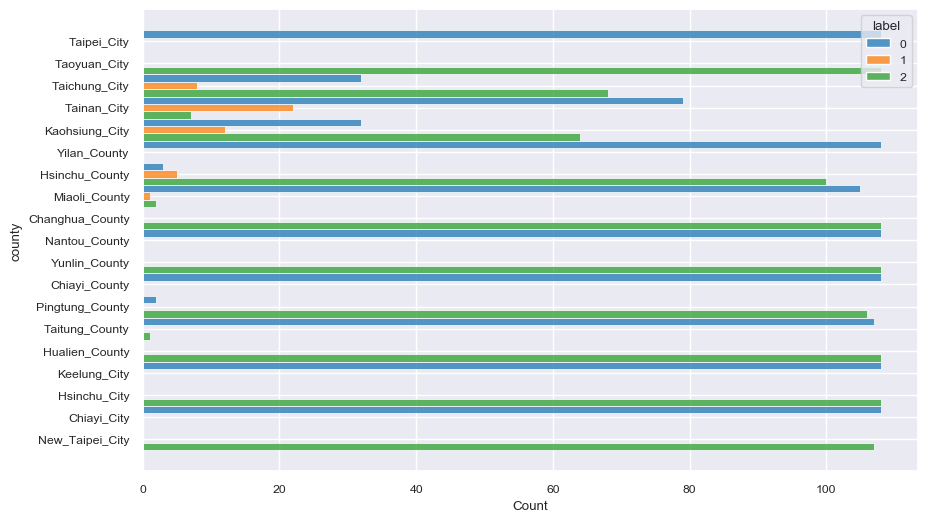

In [8]:
sns.histplot(data=df_for_analyze.loc[df_for_analyze['label']!=-1],y='county',hue='label', multiple="dodge",palette='tab10',bins=100)
plt.show()

In [9]:
import os
import tensorflow as tf

tf.config.experimental.list_physical_devices('GPU') 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [10]:
model = joblib.load("./model/traffic_model.kpl")
minmax_scaler = joblib.load("./model/minmax_scaler.kpl")

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [11]:
X_train,y_train,X_val,y_val,X_test,y_test,minmax_scaler,dic_feature_cols = cf.create_training_data(df_for_analyze,12,
                                                                                                   is_binary=False,
                                                                                                   minmax_scaler=minmax_scaler,
                                                                                                   encoder_path ='./model/encoder.pkl',
                                                                                                   decoder_path ='./model/decoder.pkl',
                                                                                                   train_size=0.6,val_size=0.2)

In [12]:
explainer = shap.GradientExplainer(model, X_train)

train_shap_values = explainer.shap_values(X_train)
val_shap_values = explainer.shap_values(X_val)
test_shap_values = explainer.shap_values(X_test)

/Users/alros/miniforge3/envs/tf/lib/python3.9/site-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


## shap value's rank:可觀察各特徵的貢獻度與重要度
- 訓練集 Top 3：county、month、encode_22
- 驗證集 Top 3：county、encode_24、month
- 測試集 Top 3：county、encode_24、encode_18

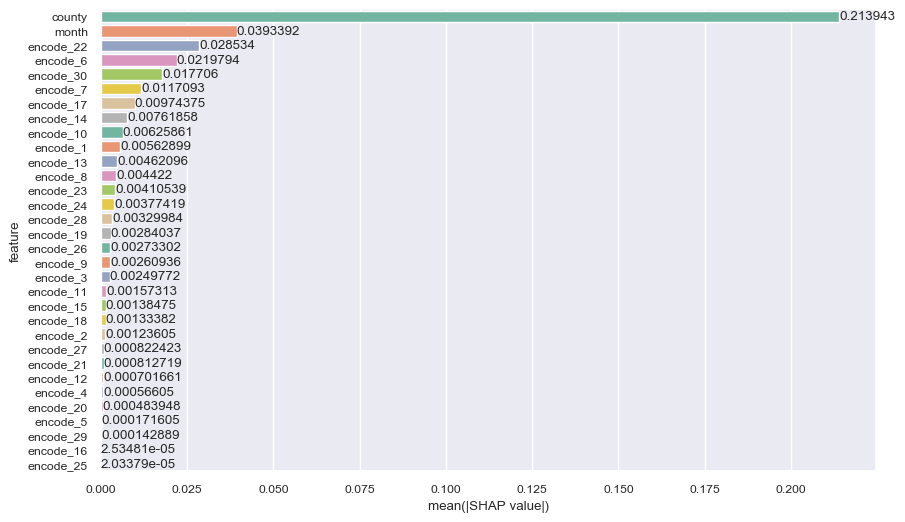

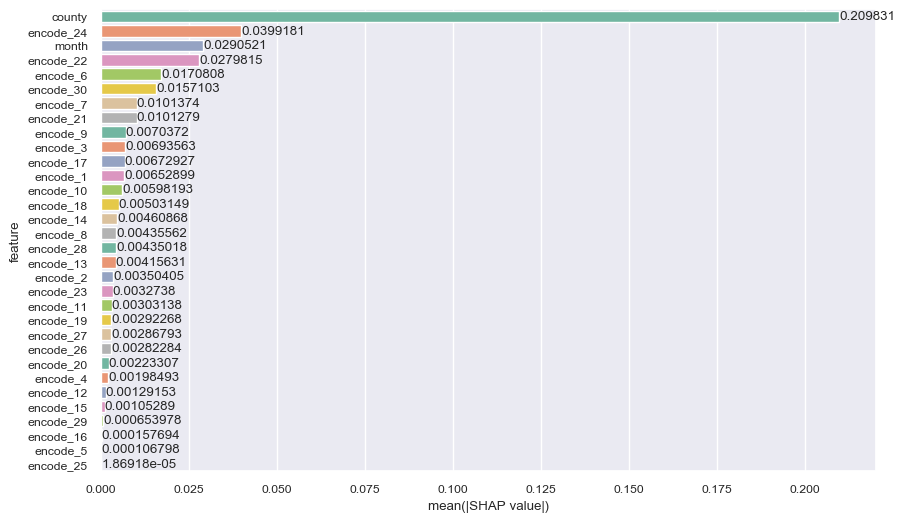

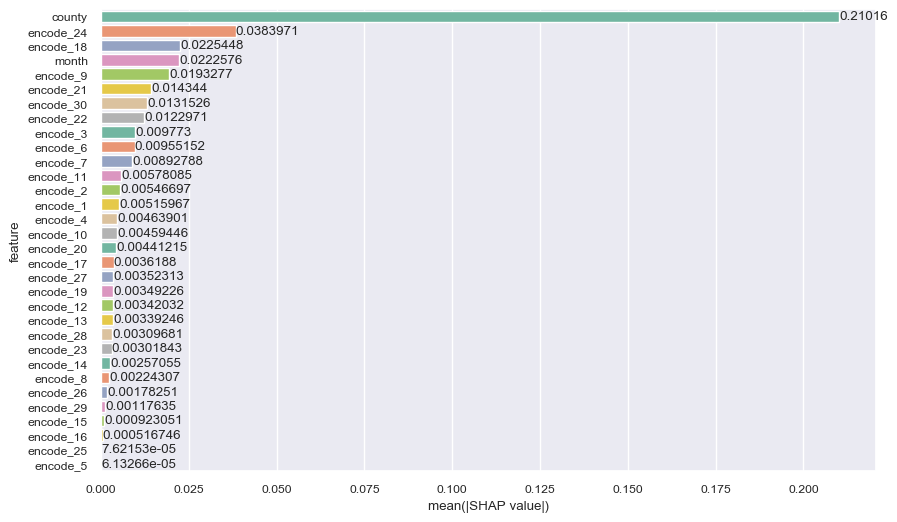

In [13]:
lst_cols = ['county']+dic_feature_cols['seq_cols']+[f'encode_{i}' for i in range(1,31)]
cf.get_Shap_value_rnak_bar(train_shap_values,lst_cols)
cf.get_Shap_value_rnak_bar(val_shap_values,lst_cols)
cf.get_Shap_value_rnak_bar(test_shap_values,lst_cols)

In [14]:
lst_countys = ['Changhua_County','Chiayi_City','Chiayi_County','Hsinchu_City','Hsinchu_County',
                'Hualien_County','Kaohsiung_City','Keelung_City','Miaoli_County','Nantou_County',
                'New_Taipei_City','Pingtung_County','Taichung_City','Tainan_City','Taipei_City',
                'Taitung_County','Taoyuan_City','Yilan_County','Yunlin_County']

In [15]:
dic_feature = cf.get_shap_value_table(test_shap_values,False,lst_countys)

## 也可針對樣本的理解其預測行為

下方為測試集的其中一筆資料在county、month、encode_0等特徵的在各類別貢獻度：

- county：各類別中貢獻度最高為Taoyuan_City，取絕對值最高的class 2且為正相關，代表此特徵拉高了預測為class 2機會。

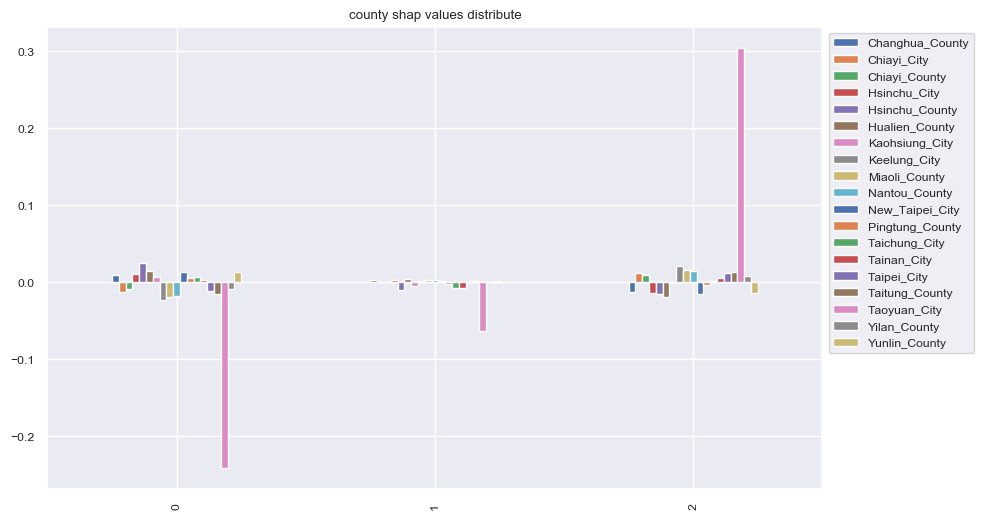

In [30]:
dic_feature['county'][dic_feature['county'].columns.to_list()[2:]][:3].plot.bar()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title('county shap values distribute')
plt.show()


In [17]:
# df_train_importance = cf.get_importance(df_for_analyze,model,False,minmax_scaler,"./model/encoder.pkl","./model/decoder.pkl",0)
# df_train_importance.to_csv('./result/0118/train_importance.csv')

# df_val_importance = cf.get_importance(df_for_analyze,model,False,minmax_scaler,"./model/encoder.pkl","./model/decoder.pkl",1)
# df_val_importance.to_csv('./result/0118/val_importance.csv')

# df_test_importance = cf.get_importance(df_for_analyze,model,False,minmax_scaler,"./model/encoder.pkl","./model/decoder.pkl",2)
# df_test_importance.to_csv('./result/0118/test_importance.csv')

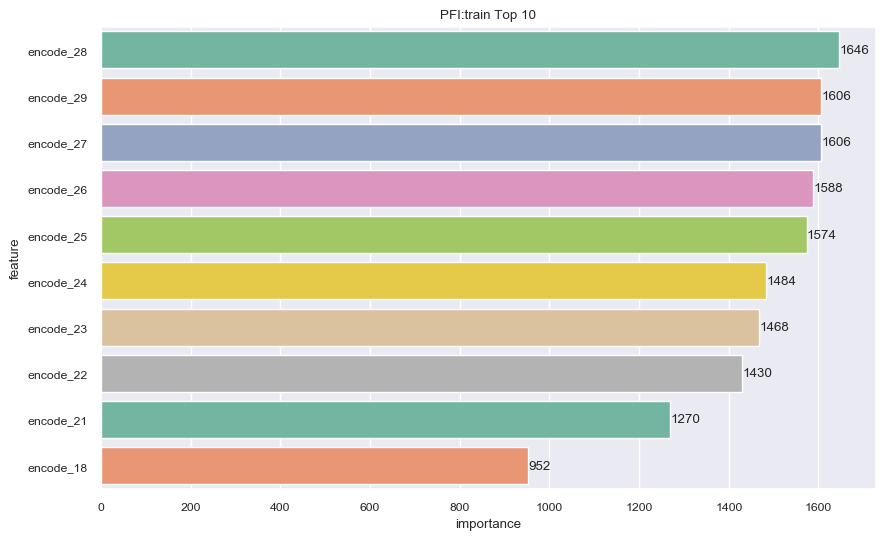

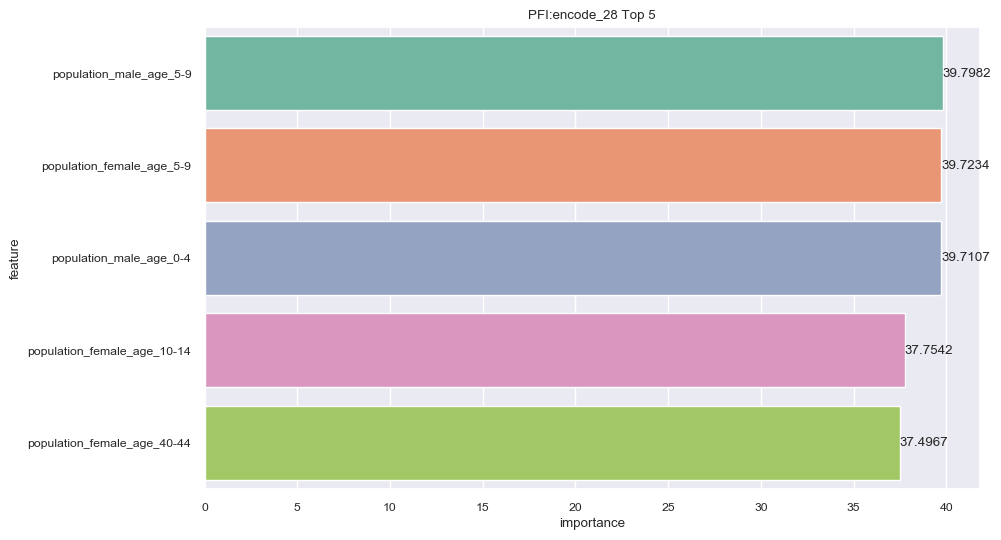

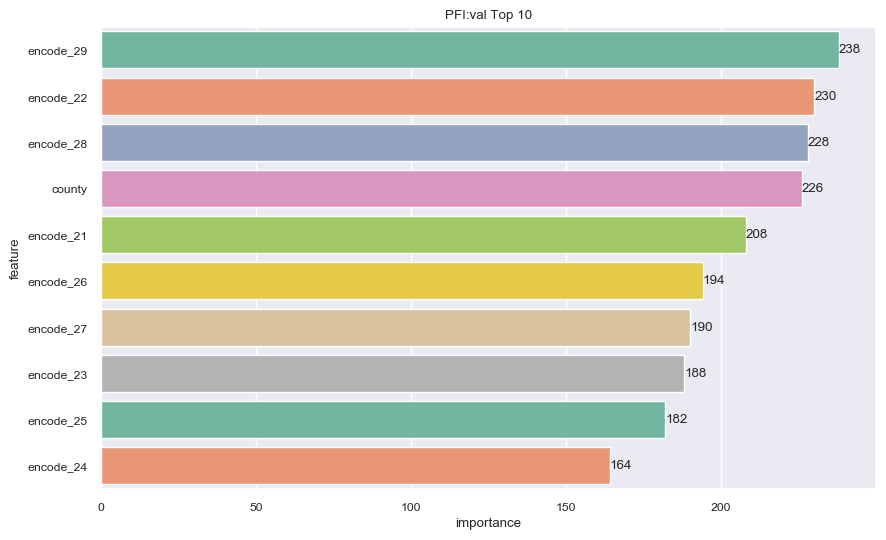

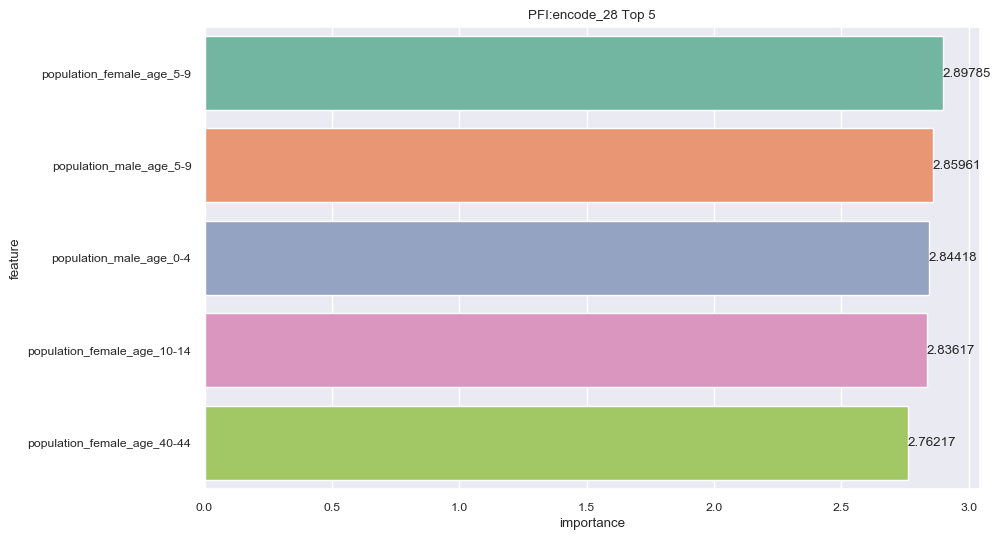

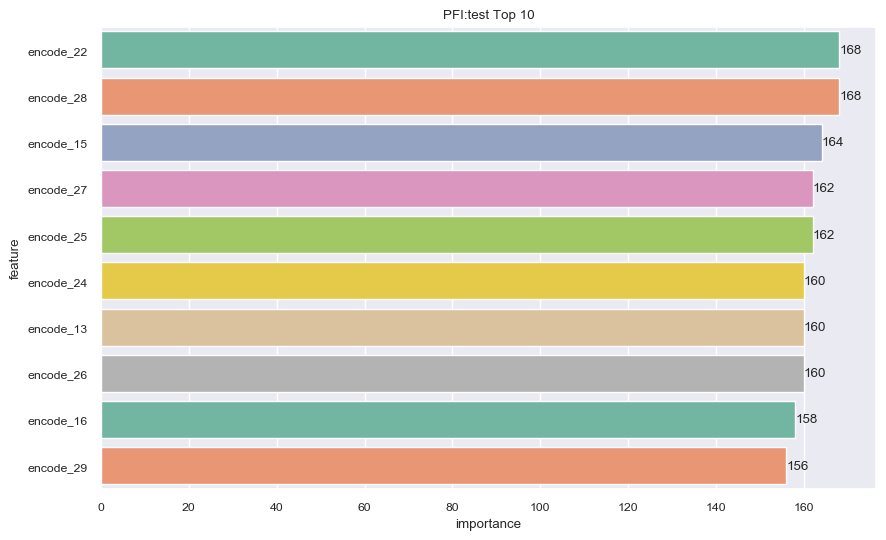

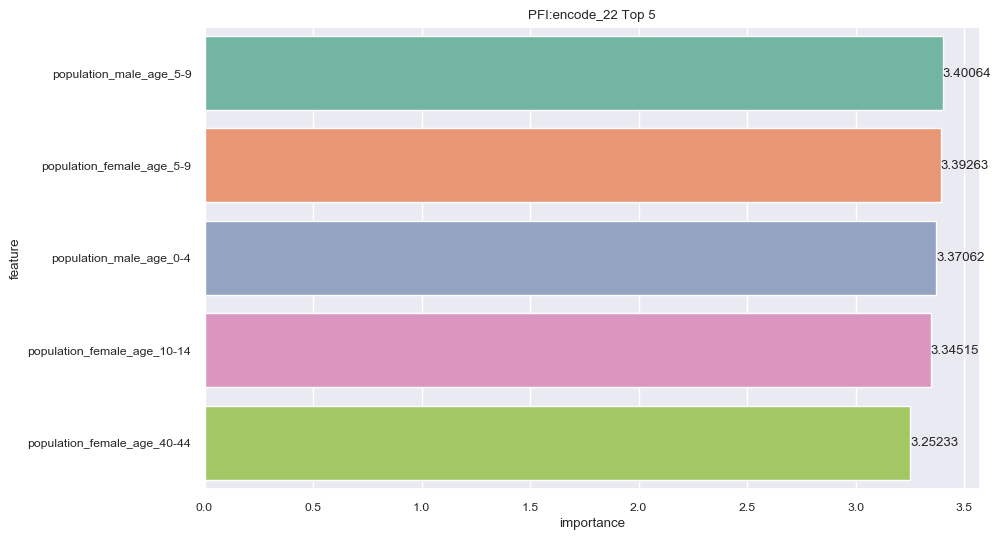

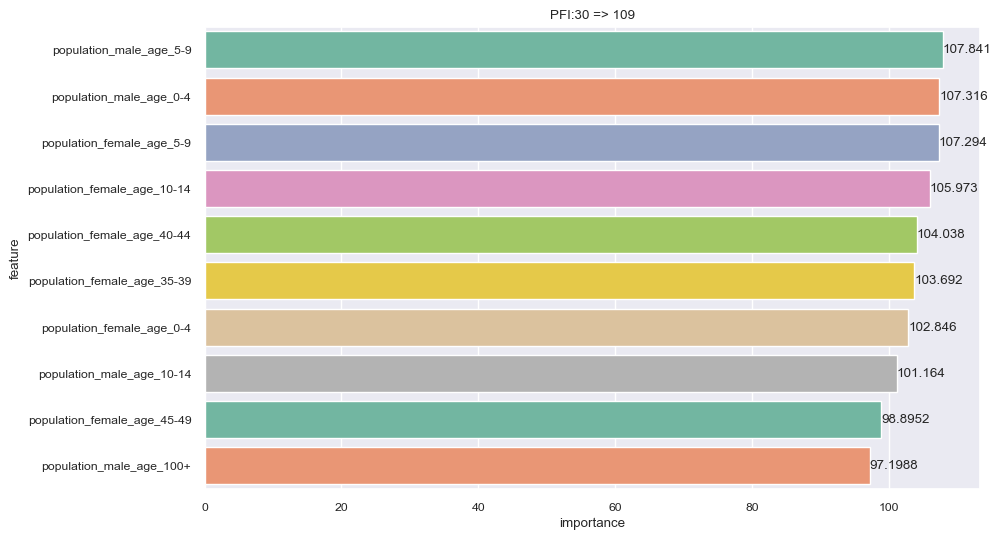

In [33]:
df_train_importance =  pd.read_csv('./result/0118/train_importance.csv',index_col=0)
df_val_importance =  pd.read_csv('./result/0118/val_importance.csv',index_col=0)
df_test_importance =  pd.read_csv('./result/0118/test_importance.csv',index_col=0)

_ = cf.get_importance_rank(df_train_importance.loc[df_train_importance['encode_feature_no']==-1],'PFI:train Top 10',10)
_ = cf.get_importance_rank(df_train_importance.loc[df_train_importance['encode_feature_no']==28],'PFI:encode_28 Top 5',5)
_ = cf.get_importance_rank(df_val_importance.loc[df_val_importance['encode_feature_no']==-1],'PFI:val Top 10',10)
_ = cf.get_importance_rank(df_val_importance.loc[df_val_importance['encode_feature_no']==29],'PFI:encode_28 Top 5',5)
_ = cf.get_importance_rank(df_test_importance.loc[df_test_importance['encode_feature_no']==-1],'PFI:test Top 10',10)
_ = cf.get_importance_rank(df_test_importance.loc[df_test_importance['encode_feature_no']==22],'PFI:encode_22 Top 5',5)
_ = cf.get_importance_rank(df_test_importance.loc[df_test_importance['encode_feature_no']!=-1],'PFI:30 => 109',10)